<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C(3)_%ED%95%A9%EC%84%B1%EA%B3%B1(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. 합성곱 신경망(CNN)

## 01. 합성곱 신경망



---

**합성곱 신경망(CNN)** : 데이터가 가진 특징들의 패턴을 학습하는 알고리즘

* 대표적으로 이미지 분류, 객체 탐지, 스타일 전이 등

### 1-1 이미지 표현

이미지(또는 영상)를 컴퓨터가 이해할 수 있게 하려면 숫자로 표현해야 한다 -> 0~255 사이의 숫자로 각 픽셀의 화소 값 나타내는 방식

* 화소 나타내는 숫자는 이미지의 강도. 숫자 클수록 더 강한 특성 나타낸다
  + 숫자 0은 완전히 검은색, 숫자 255는 흰색

* 컬러 이미지는 R(빨강), G(초록), B(파랑) 채널로 구성된 3장의 이미지 겹쳐서 표현. 각 채널 이미지는 0~255 사이의 숫자로 나타냄

### 1-2 합성곱(Convolution)

**합성곱 연산** : 입력 이미지에 대하여 일반적으로 정방형 크기를 가지는 커널을 사용하여, 입력 이미지에 대한 특성을 추출하는 방법

* 합성곱 연산을 통해서 추출된 이미지 = 특성맵

* 입력 이미지의 일부분에 커널이 겹치도록 투영해 합성곱 연산 수행 -> 합성곱 연산은 element-wise 곱셈 연산을 수행 후 모두 더한 값으로 단일 스칼라 값이 나온다

* 커널 사이즈가 3x3인 경우 총 9개의 가중치(weight). 오차 역전파 시 커널의 가중치 업데이트 -> 완전 연결층 사용할 때보다 연산량이 훨씬 적다는 장점

### 1-3 채널(channel)

**채널** : 입력 이미지를 구성하는 2차원 배열의 개수

* 흑백 이미지는 채널의 개수가 1개인 이미지
* 컬러 이미지는 R,G,B 3개의 채널 가지는 이미지
  + 세로 5픽셀, 가로 5픽셀의 컬러 이미지 shape => (5,5,3)

* 특성맵의 생성 과정

입력 이미지의 채널 개수만큼 커널 생성 -> 각 채널마다 하나씩 커널 적용해 합성곱 연산 수행(입력 이미지의 채널 개수만큼 생성) -> element-wise 덧셈 연산으로 모두 더해 최종 특성맵 생성

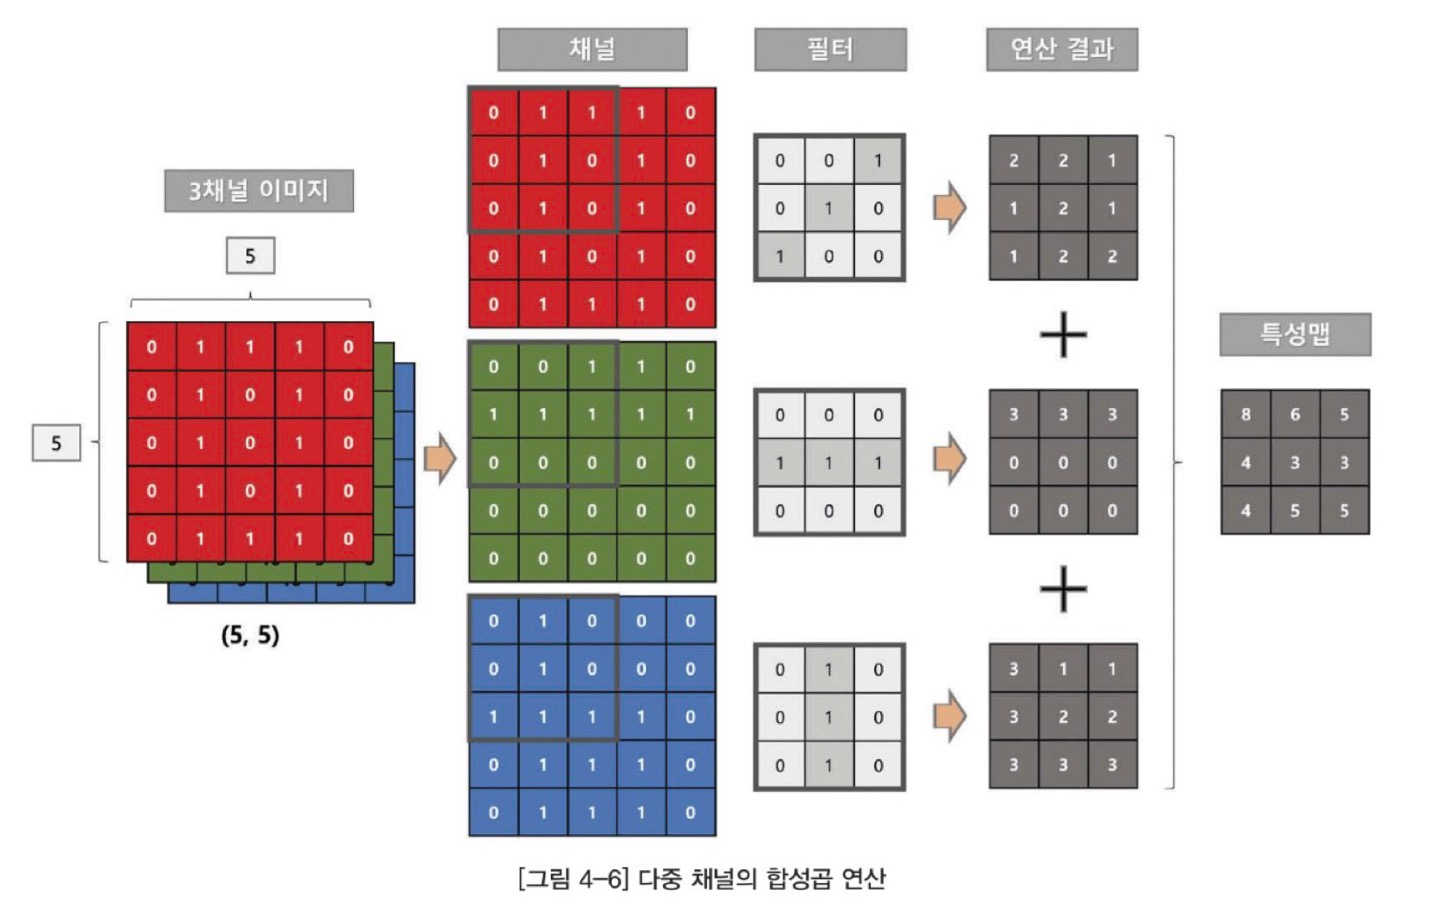

* 업데이트될 파라미터의 개수 = **1개 커널의 사이즈 x 입력 채널 수 x 출력 필터 수 + bias**

### 1-4 스트라이드(stride)

커널은 좌측 상단부터 입력 이미지 기준으로 우측으로 이동하면서 합성곱 연산하는데, 이때 이동하는 간격을 **스트라이드(stride)**로 정의

* 주로 1 또는 2로 설정
  + 2로 설정하면 특성맵의 크기가 1/2로 줄어들게 된다

* 케라스에서 제공하는 Conv2D 레이어의 **strides**매개변수에 스트라이드 지정

### 1-5 패딩(padding)

추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 **패딩(padding)** 설정

* 일반적으로 zero-padding 사용 : 입력 이미지의 가장 자리에 0으로 채워진 패딩 값으로 채운 후 추출 -> 특성맵 크기 줄어들지 않는다

* 케라스의 Conv2D 레이어에서 **padding='same'**로 설정하면 zero-padding 적용. 기본값은 padding='valid'

### 1-6 특성맵(feature map) 사이즈

**(Output Height, Output Width) = ( (Image Height + 2P - Kernel Height) / S + 1, (Image Width + 2P - Kernel Width) / S + 1 )**

* Image Height, Image Width : 입력 크기(input size)
* Kernel Height, Kernel Width : 필터 크기(kernel size)
* S : 스트라이드(strides)
* P : 패딩(padding)
* Output Height, Output Width : 출력 크기(output size)

### 1-7 풀링(pooling)

**풀링(pooling)** 레이어 : 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어

* 이점 : 이미지 축소를 통해 연산량 감소, 과대적합 방지

* 최대 풀링(max pooling)과 평균 풀링(average pooling)
  + ex 최대 풀링의 커널 크기를 2x2로 설정. 스트라이드 2로 설정 -> 입력 이미지 대비 총 1/4 크기로 줄어든다

## 02. 간단한 모델 생성



---

mnist 손글씨 데이터셋 가지고 간단한 구조의 합성곱 신경망 모델

### 2-1 데이터 로드 및 전처리

In [ ]:
# tensorflow 모듈 import
import tensorflow as tf

* 데이터셋 불러오면 훈련 셋과 검증 셋으로 구분해 투플 형태로 정리
  + 훈련 셋의 개수는 60,000개, 검증 셋의 개수는 10,000개
  + 가로, 세로 각각 28픽셀인 손글씨 이미지와 손글씨가 나타내는 숫자 레이블(정답)이 매칭되어 있다

In [ ]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid, y_valid)=mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


* 훈련 셋의 첫 번째 이미지 출력

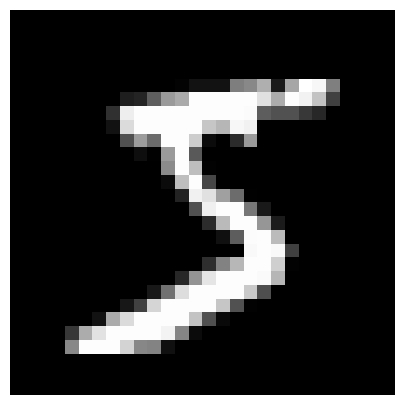

In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx], cmap='gray')
  plt.axis('off')
  plt.show()

plot_image(x_train, 0)

* 픽셀의 최소값, 최대값 출력 -> 이미지 픽셀이 0~255 범위의 숫자로 구성됨

In [ ]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


* 입력 이미지 픽셀 값을 정규화 변환 -> 최대값 255로 나누어 0~1 범위로 스케일 정규화

In [ ]:
# 정규화(Normalization)
x_train = x_train/255.0
x_valid=x_valid/255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


* mnist 데이터셋은 색상 나타내는 채널 1개인 모노 컬러 이미지로 구성 -> CNN 모델에 주입하기 위해 색상 나타내는 채널 추가

* [] 안에서 채널을 추가하고자 하는 위치에 **tf.newaxis** 작성
  + 가장 마지막 축에 채널 추가하기 위해 [..., tf.newaxis]
  + (60000, 28, 28) -> (60000, 28, 28, 1)

In [ ]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train.shape, x_valid.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28) (10000, 28, 28)


### 2-2 Sequential API로 모델 생성 및 학습


* Sequential API 사용하여 합성곱 레이어 1개, 풀링 레이어 1개를 적용하는 간단한 모델 생성

In [ ]:
# Sequential API를 사용해 샘플 모델 생성
model=tf.keras.Sequential([
    #Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', # (3,3) 크기의 서로 다른 32가지 종류 커널
                           input_shape=(28, 28, 1), name='conv'),
    #max pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),
    #classifier 출력층
    tf.keras.layers.Flatten(),    # 1차원 배열로 펼쳐준다
    tf.keras.layers.Dense(10, activation='softmax')   # 다중 분류 문제
])

* 앞 모델 구조에 옵티마이저, 손실함수, 평가지표 설정해 주고 컴파일하면 모델 인스턴스 생성

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 54s 27ms/step - loss: 0.2336 - accuracy: 0.9344 - val_loss: 0.0949 - val_accuracy: 0.9738
Epoch 2/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0837 - accuracy: 0.9762 - val_loss: 0.0655 - val_accuracy: 0.9795
Epoch 3/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0615 - accuracy: 0.9819 - val_loss: 0.0546 - val_accuracy: 0.9824
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0586 - val_accuracy: 0.9819
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0538 - val_accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0356 - accuracy: 0.9888 - val_loss: 0.0570 - val_accuracy: 0.9837
Epoch 7/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0295 - accuracy: 0.9913 - val_loss: 0.0522 -

* 모델의 학습된 가중치 사용하여 손실과 평가지표 계산

In [ ]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 2s 6ms/step - loss: 0.0561 - accuracy: 0.9836


[0.05606510490179062, 0.9836000204086304]

* 10 epoch 동안 모델의 예측 오차와 정확도를 그래프로 그리는 함수 정의하고 실행
  + 훈련 결과를 history 객체에 저장

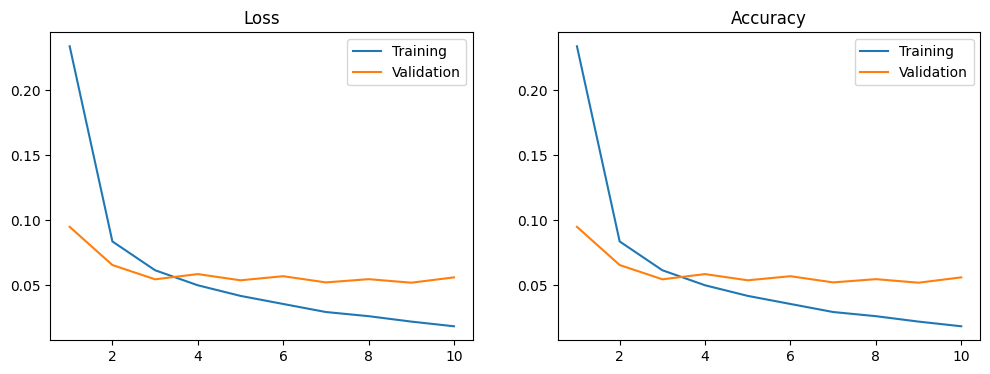

In [ ]:
def plot_loss_acc(history, epoch):
  loss, val_loss=history.history['loss'], history.history['val_loss']
  acc, val_acc=history.history['accuracy'], history.history['val_accuracy']

  fig, axes=plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), loss, label='Training')
  axes[1].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 10)

=> 검증 셋의 손실은 어느 수준에서 더 이상 낮아지지 않는다. 4 epoch 이후부터는 모델이 과대적합으로 진행되었다

### 2-3 모델 구조 파악

* (28, 28, 1) 형태의 입력 텐서가 Conv2D 거치면서 (26, 26, 32) 형태로 변환
  + (3,3) 크기의 합성곱 필터 사용해서 이미지 가로, 세로 크기 2씩 줄어든다
  + 서로 다른 32개의 필터 적용해 특성맵 32개 생성
  + (2,2) 크기의 풀링 레이어 적용해 이미지 크기 1/2로 줄어든다 (13,13,32) 텐서로 변환
  + Flatten 층에서 1차원 텐서로 펼쳐 13x13x32원소 갖는 1차원 벡터

In [ ]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


* 생성된 모델 인스턴스의 **input** 속성으로부터 입력 레이어의 텐서 추출 (None, 28, 28, 1) 형태
  + 가장 앞에 있는 축(axis=0)의 None값 : 배치 크기가 들어오는 위치로서 배치 크기로 어떤 값이든 가능하다

In [ ]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

* 모델의 출력 텐서는 **output** 속성으로 선택

In [ ]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

=> 10개 노드 갖는 1차원 벡터 형태

* 모델을 구성하는 레이어들을 추출하려면 **layers** 속성 확인
  + 파이썬 리스트 형태로 레이어 객체 담아서 보여줘

In [ ]:
# 레이어
model.layers

* 4개의 레이어로 구성된 모델 작성. 첫 번째 레이어 선택

In [ ]:
# 첫 번째 레이어 선택
model.layers[0]

* 각 레이어에 입력되는 텐서를 따로 선택하는 것도 가능
  + 앞 Conv2D 레이어는 입력 데이터 그대로 들어가 (None, 28,28,1) 형태

In [ ]:
# 첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

* 각 레이어에 출력되는 텐서도 확인 가능
  + Conv2D 레이어 거치면서 픽셀 사이즈 2씩 줄어들고 채널 개수가 32개로 늘어나 (None, 26,26,32) 형태

In [ ]:
# 첫 번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

* 각 레이어의 가중치 행렬 추출 가능 **weights**속성을 각 레이어 인스턴스에 적용

In [ ]:
# 첫 번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[ 0.4581927 ,  0.0751451 ,  0.3701094 ,  0.40067562,
           -0.33056667, -1.0409027 , -0.9572224 ,  0.27609697,
           -0.755682  , -0.14596301, -0.53419524, -0.69978905,
            0.07121153,  0.64011174,  0.11085322, -0.0216979 ,
           -0.0708004 , -0.42570072, -0.29047653, -0.13903669,
           -0.68595535, -0.7988124 ,  0.17825633, -0.15264131,
           -0.00682336, -0.13791457,  0.3630589 , -0.6996519 ,
            0.08047026, -1.0756581 ,  0.1696911 , -0.3727628 ]],
 
         [[-0.12770957, -0.5858017 , -0.07014239,  0.30277675,
            0.03809483, -0.03602041, -0.9594836 ,  0.22081657,
            0.17257816, -0.8890184 ,  0.17055997, -0.0207667 ,
            0.3165413 ,  0.4993916 ,  0.14329135,  0.1312955 ,
            0.632233  , -0.22925785,  0.2197053 ,  0.5330192 ,
            0.07497296, -0.5776653 ,  0.26951164,  0.38128328,
           -0.4630812 , -0.35636088,  0.36

>> tf.Variable : 가중치와 같이 모델 학습 과정에 값이 업데이트되는 경우 사용한다

>> 첫 번째 변수는 'conv/kernel:0' -> 커널(합성곱 필터) 행렬의 가중치

>>  두 번째 변수는 'conv/bias:0' -> 각 커널의 상수항(bias)

>> 커널 가중치의 shape = (3, 3, 1, 32). (3,3)은 필터의 크기, (1)은 입력층의 채널 개수, (32)는 출력층의 채널 개수

>> 상수항(bias) 가중치의 shape = (32, )이고 출력층의 채널 수

>> layer[0]의 총 학습 가능한 파라미터 수 = 커널(3x3x1x32) + 상수항(32) = 320개

* 커널 행렬의 가중치 또는 상수항 따로 선택 가능

In [ ]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 0.4581927 ,  0.0751451 ,  0.3701094 ,  0.40067562,
          -0.33056667, -1.0409027 , -0.9572224 ,  0.27609697,
          -0.755682  , -0.14596301, -0.53419524, -0.69978905,
           0.07121153,  0.64011174,  0.11085322, -0.0216979 ,
          -0.0708004 , -0.42570072, -0.29047653, -0.13903669,
          -0.68595535, -0.7988124 ,  0.17825633, -0.15264131,
          -0.00682336, -0.13791457,  0.3630589 , -0.6996519 ,
           0.08047026, -1.0756581 ,  0.1696911 , -0.3727628 ]],

        [[-0.12770957, -0.5858017 , -0.07014239,  0.30277675,
           0.03809483, -0.03602041, -0.9594836 ,  0.22081657,
           0.17257816, -0.8890184 ,  0.17055997, -0.0207667 ,
           0.3165413 ,  0.4993916 ,  0.14329135,  0.1312955 ,
           0.632233  , -0.22925785,  0.2197053 ,  0.5330192 ,
           0.07497296, -0.5776653 ,  0.26951164,  0.38128328,
          -0.4630812 , -0.35636088,  0.36816272,  0.097771

In [ ]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.4639061 , -0.18135153, -0.3820559 , -0.38396516, -0.30067697,
       -0.01302601, -0.00854826, -0.24477129, -0.08828327, -0.01565699,
       -0.12225047, -0.04721   , -0.24052624, -0.00684307, -0.27202705,
       -0.2825244 , -0.00556148, -0.06743636, -0.3040676 , -0.00998475,
       -0.15915857, -0.13258792, -0.00890132, -0.220688  , -0.20525536,
       -0.28909263, -0.35507858, -0.17529325, -0.32542378,  0.22713892,
       -0.04096882,  0.00742864], dtype=float32)>

* 레이어 이름(name 속성) 사용하여 해당 레이어 선택 가능

In [ ]:
# 레이어 이름 사용해 레이어 선택
model.get_layer('conv')

* 모델에 입력 데이터를 넣어주고, 모델의 첫 번째와 두 번째 레이어의 출력을 최종 출력으로 갖는 activator 모델 정의

In [ ]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가 (첫 번째, 두 번째 레이어)
activator = tf.keras.Model(inputs=model.input,
                           outputs=[layer.output for layer in model.layers[:2]])
activations=activator.predict(x_train_in[0][tf.newaxis, ...])

len(activations)

1/1 [==============================] - 0s 96ms/step


2

* 2개의 출력 텐서 중에서 첫 번째 텐서는 Conv2D 레이어의 출력

In [ ]:
# 첫 번재 레이어 conv의 출력층
conv_activation=activations[0]
conv_activation.shape

(1, 26, 26, 32)

=> 텐서의 형태는 (1,26,26,32). 여기서 1은 입력 이미지의 개수

* 첫 번째 레이어에서 출력되는 특성맵 이미지를 32개 커널별로 구분하여 시각화
  + 각 커널은 입력 이미지로부터 서로 다른 피처(특징)을 추출하는 역할

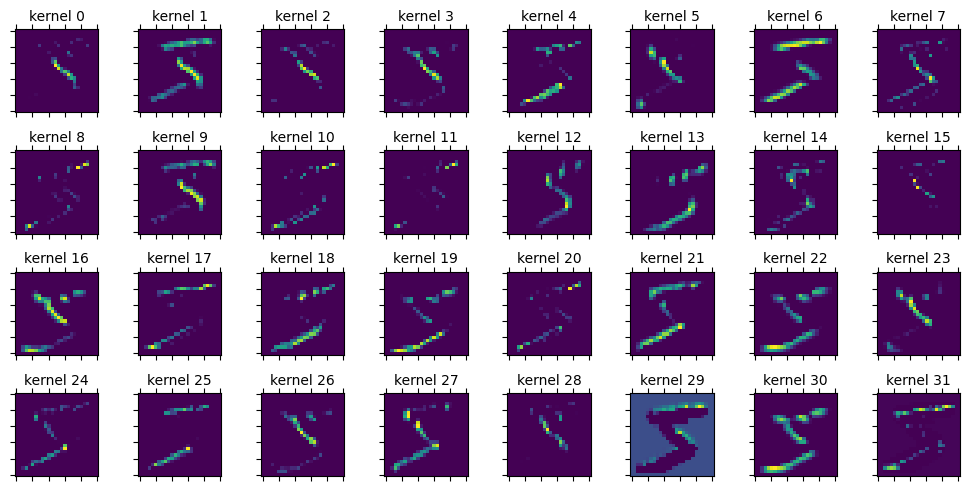

In [ ]:
# Convolution 시각화
fig, axes=plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
  axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

* 두 번째 레이어는 최대 풀링 레이어

In [ ]:
# 두번째 레이어 pool 출력층
pooling_activation=activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


=> 출력하는 텐서는 (1,13,13,32) 형태

* 각 커널별로 출력되는 특성맵 이미지 시각화

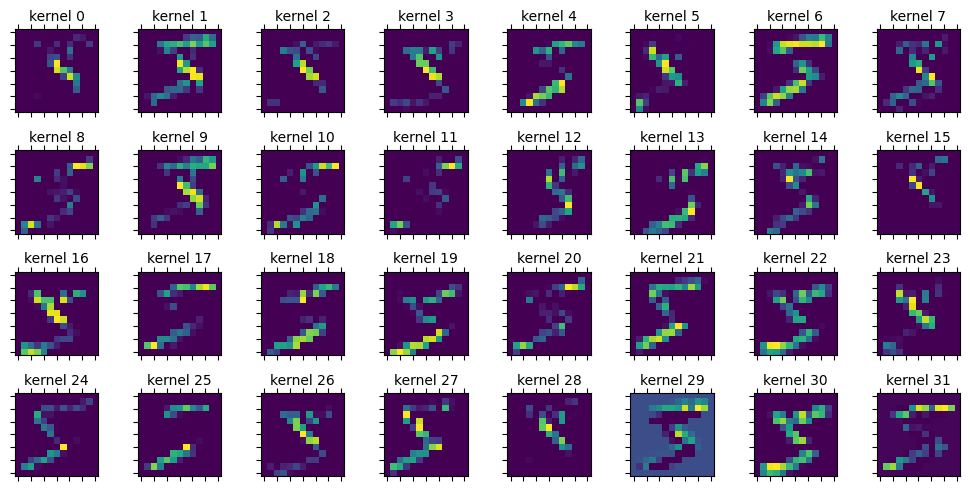

In [ ]:
# 시각화
fig, axes=plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
  axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

=> Conv2D 출력 이미지에 비하여 화소 크기가 굵어짐

최대 풀링은 인근 픽셀들을 모아서 최대값으로 고정 -> 픽셀 수는 줄이면서 특징을 더욱 강하게 드러낼 수 있다

## 03. 복잡한 모델 생성



---


텐서플로 케라스의 Functional API 사용하면, Sequential API로 구현할 수 없는 복잡한 구조의 모델 정의 가능

ex) 각 레이어를 기준으로 입력이 2개 이상이거나 출력이 2개 이상인 모델, 중간 레이어를 건너뛰고 뒤쪽에 있는 레이어로 출력 텐서를 전달하는 방식의 직접 연결.

### 3-1 데이터셋 준비

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
#mnist 손글씨 이미지 데이터 로드
mnist=tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid)=mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


* 원본 정답 외에 홀수인지 짝수인지 판단하는 정답 (y_odd)를 추가
  + 원본 mnist 데이터셋은 0~9까지 숫자

In [ ]:
# 새로운 출력 값 배열 생성 (홀수 : 1, 짝수 : 0)
y_train_odd=[]
for y in y_train:
  if y%2==0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)

y_train_odd=np.array(y_train_odd)
y_train_odd.shape

(60000,)

* 원본 y_train 배열과 홀짝으로 분류한 y_train_odd 배열 동시에 출력해 비교

In [ ]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


* 검증 데이터셋에 대해서도 y_valid_odd 배열 만들기

In [ ]:
# Validation 데이터셋 처리
y_valid_odd=[]
for y in y_valid:
  if y%2==0:
    y_valid_odd.append(0)
  else:
    y_valid_odd.append(1)

y_valid_odd=np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

* 입력 이미지 데이터를 255로 나눠서 정규화
  + 모노 컬러 이미지 -> 새로운 축 추가. 채널 개수 1개로 지정
  + expand_dims() 함수에서 축의 인덱스로 -1 지정하면 새로운 축은 끝에 추가
  + (60000, 28, 28) -> (60000, 28, 28, 1)

In [ ]:
# 정규화
x_train=x_train/255.0
x_valid=x_valid/255.0

# 채널 추가
x_train_in=tf.expand_dims(x_train, -1)
x_valid_in=tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### 3-2 Functional API로 다중 입력, 다중 출력 레이어 생성

Functional API 사용하면 다중 입력 또는 다중 출력 같은 구조 만들 수 있다

다음 코드 > 입력 레이어 inputs의 경우, Conv2D 레이어와 Flatten 레이어의 입력으로 사용(2개의 출력) -> 각각 다른 레이어의 입력으로 사용. 최종적으로 Concatenate 레이어에서 합쳐져 Dense 레이어 통과

=> 함수의 입력과 출력으로 표현할 수 있어서 자유롭게 모델 구조 정의할 수 있는 장점

In [ ]:
# Functional API 를 사용하여 모델 생성

inputs=tf.keras.layers.Input(shape=(28, 28, 1))

conv=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool=tf.keras.layers.MaxPooling2D((2,2))(conv)
flat=tf.keras.layers.Flatten()(pool)

flat_inputs=tf.keras.layers.Flatten()(inputs)
concat=tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs=tf.keras.layers.Dense(10, activation='softmax')(concat)

model=tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

* 케라스 utils 모듈의 **plot_model** 함수 사용해 모델 입력하면 모델 구조 그래프로 출력 + 별도의 파일로도 저장 가능

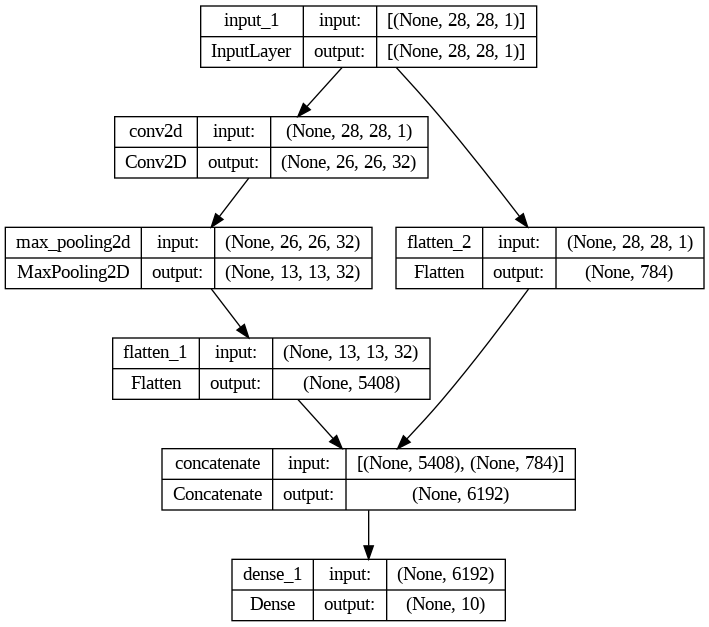

In [ ]:
# 모델 구조 출력 및 이미지 파일로 저장
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

* 모델 컴파일, 훈련, 예측 성능 평가

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=model.fit(x_train_in, y_train, validation_data=(x_valid, y_valid), epochs=10)

# 모델 성능
val_loss, val_acc=model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.2177 - accuracy: 0.9377 - val_loss: 0.1027 - val_accuracy: 0.9704
Epoch 2/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0868 - accuracy: 0.9750 - val_loss: 0.0743 - val_accuracy: 0.9772
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0632 - accuracy: 0.9816 - val_loss: 0.0676 - val_accuracy: 0.9785
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.0608 - val_accuracy: 0.9813
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0430 - accuracy: 0.9868 - val_loss: 0.0549 - val_accuracy: 0.9823
Epoch 6/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0558 - val_accuracy: 0.9825
Epoch 7/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0573 -

### 3-3 다중 출력 분류 모델

두 가지 서로 다른 분류 문제를 예측하는 다중 출력 모델

0~9까지 숫자를 맞추는 분류 문제와 홀수, 짝수를 맞추는 분류 문제를 동시에 풀어내는 모델 -> 최종 분류기의 출력 레이어를 2개 만드는 것이 핵심


In [ ]:
# Functional API를 사용해 모델 생성

inputs=tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv=tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool=tf.keras.layers.MaxPooling2D((2,2), name='maxpool_layer')(conv)
flat=tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs=tf.keras.layers.Flatten()(inputs)
concat=tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs=tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs=tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model=tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

* 모델의 입력 텐서와 출력 텐서를 화면에 표시

In [ ]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


=> 입력은 하나. 출력은 10개인 텐서와 1개인 텐서로 두 개 확인

* 모델 구조를 그림으로

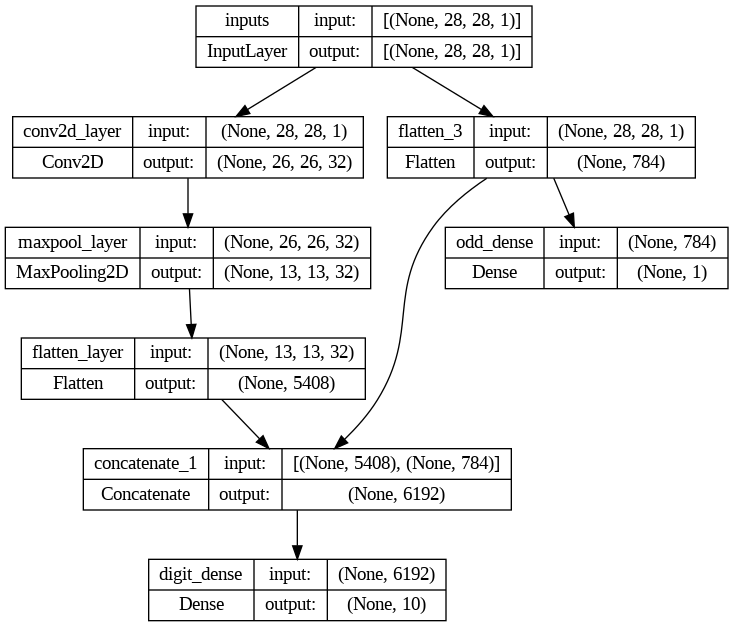

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

* 모델을 컴파일할 때 주의할 내용
  + 모델 정의할 때 각각의 출력 Dense 레이어에 name 속성으로 지정한 이름을 key로 하고, 해당 key에 해당하는 레이어에 적용할 손실함수와 가중치를 딕셔너리 형태로 지정
  + fit() 메소드 적용할 때도 출력 값 2개 지정. 레이어 이름 속성을 key로 하는 딕셔너리 형태로 각각의 출력에 맞는 정답 배열 입력

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss={'digit_dense': 'sparse_categorical_crossentropy',
                    'odd_dense':'binary_crossentropy'},
              loss_weights={'digit_dense':1, 'odd_dense':0.5},
              # loss = 1.0 * sparse_categorical_crossentropy + 0.5 * binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history=model.fit({'inputs':x_train_in},
                  {'digit_dense':y_train, 'odd_dense':y_train_odd},
                   validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd}), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 39s 20ms/step - loss: 0.3711 - digit_dense_loss: 0.2084 - odd_dense_loss: 0.3253 - digit_dense_accuracy: 0.9397 - odd_dense_accuracy: 0.8642 - val_loss: 0.2264 - val_digit_dense_loss: 0.0884 - val_odd_dense_loss: 0.2760 - val_digit_dense_accuracy: 0.9730 - val_odd_dense_accuracy: 0.8879
Epoch 2/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2140 - digit_dense_loss: 0.0781 - odd_dense_loss: 0.2718 - digit_dense_accuracy: 0.9773 - odd_dense_accuracy: 0.8913 - val_loss: 0.2045 - val_digit_dense_loss: 0.0727 - val_odd_dense_loss: 0.2635 - val_digit_dense_accuracy: 0.9773 - val_odd_dense_accuracy: 0.8968
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1920 - digit_dense_loss: 0.0605 - odd_dense_loss: 0.2631 - digit_dense_accuracy: 0.9819 - odd_dense_accuracy: 0.8956 - val_loss: 0.1944 - val_digit_dense_loss: 0.0646 - val_odd_dense_loss: 0.2597 - val_digit_dense_accuracy: 0.9787 -

* 모델 성능 평가

In [ ]:
# 모델 성능
model.evaluate({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd})

313/313 [==============================] - 2s 7ms/step - loss: 0.1840 - digit_dense_loss: 0.0558 - odd_dense_loss: 0.2564 - digit_dense_accuracy: 0.9840 - odd_dense_accuracy: 0.9020


[0.18395918607711792,
 0.05575231462717056,
 0.25641363859176636,
 0.984000027179718,
 0.9020000100135803]

* 검증 데이터셋의 인덱스 0에 해당하는 이미지 출력 -> 숫자 7에 대한 손글씨 이미지

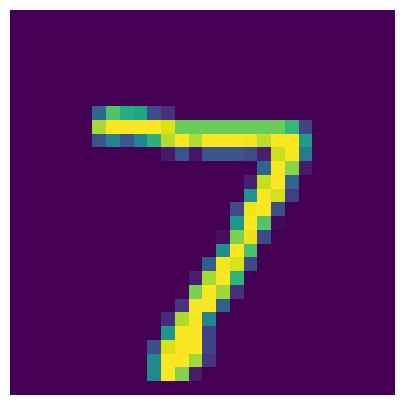

In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid, 0)

* 검증 데이터셋의 모든 이미지 데이터 입력해 2개의 분류 문제에 대한 예측 확률 구하기
  + 첫 번째 예측 값은 10개 분류 레이블에 대한 확률. 두 번째 예측 값은 홀수일 확률

In [ ]:
digit_preds, odd_preds=model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 3s 9ms/step
[1.3698035e-13 2.5675434e-10 7.8934598e-10 3.6041135e-07 2.6186852e-12
 2.8895233e-12 8.2568119e-21 9.9999958e-01 6.7498701e-10 1.3142230e-09]
[0.9995196]


* argmax 함수 이용해 예측 확률을 실제 정답 레이블로 변환

In [ ]:
digit_labels=np.argmax(digit_preds, axis=1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

* 홀수, 짝수 여부에 대한 예측 레이블 출력. 임계값으로 0.5 지정
  + 홀수일 확률이 0.5보다 큰 경우 홀수로 분류

In [ ]:
odd_labels=(odd_preds>0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

<ipython-input-44-b68f671b10f9>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  odd_labels=(odd_preds>0.5).astype(np.int).reshape(1, -1)[0]


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

### 3-4 전이 학습(Transfer Learning)

**Transfer Learning** : 앞서 훈련한 모델의 일부를 가져와서 그대로 사용하고, 최종 출력층만 새롭게 추가하여 모델 재구성하는 것, 즉 기존에 학습된 모델 활용해 새로운 모델 만들어 내는 개념

* 입력 레이어부터 'flatten_layer'라는 name 속성 갖는 Flatten 층까지 해당하는 부분 따로 추출하여, base_model 객체 만들기

In [ ]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output=model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


* 모델 구조 시각화

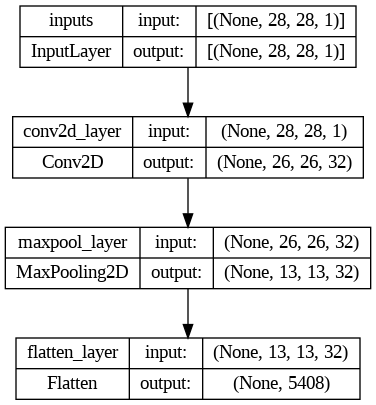

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

* Sequential API 사용하여 base_model 레이어로 추가, 최종 분류기 역할을 하는 Dense 레이어를 새롭게 이어서 추가

In [ ]:
# Sequential API 적용
digit_model=tf.keras.Sequential([
    base_model, tf.keras.layers.Dense(10, activation='softmax')
])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


* 모델 구조 출력

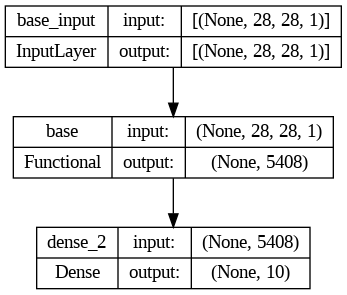

In [ ]:
tf.keras.utils.plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

=> 최종적으로 노드 10개를 가진 분류기 역할을 하는 Dense 레이어 추가된 것 확인

* 모델 컴파일, 훈련

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1289 - accuracy: 0.9642 - val_loss: 0.0628 - val_accuracy: 0.9791
Epoch 2/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0584 - accuracy: 0.9826 - val_loss: 0.0527 - val_accuracy: 0.9826
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0446 - accuracy: 0.9863 - val_loss: 0.0543 - val_accuracy: 0.9819
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0356 - accuracy: 0.9894 - val_loss: 0.0485 - val_accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0571 - val_accuracy: 0.9821
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0489 - val_accuracy: 0.9849
Epoch 7/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0555 -

* 모델 인스턴스는 **trainable** 속성 가지고 있다
  + False로 지정하면 모델의 파라미터 값이 고정되어 훈련을 통해서 업데이트되지 않는다

In [ ]:
# 베이스 모델의 가중치 고정 (Freeze Model)

base_model_frozen=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable=False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


=> 훈련 가능한 파라미터 개수가 0으로 확인

* 파라미터 고정한 base_model_input 모델과 새로운 분류기 역할을 하는 Dense 레이어를 Functional API 적용하여 구성

In [ ]:
# Functional API 적용
dense_output=tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen=tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

=> 총 파라미터 개수는 54410개. 고정한 320개의 파라미터는 훈련 불가능하다는 것 표시

훈련 가능한 파라미터는 Flatten 레이어의 출력 5408개와 Dense레이어의 10개 노드 사이의 가중치만 해당 -> Conv2D 레이어의 파라미터 320개는 포함되지 않게 된다는 뜻

* 모델 컴파일, 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model_frozen.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1174 - accuracy: 0.9688 - val_loss: 0.0615 - val_accuracy: 0.9804
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0485 - accuracy: 0.9858 - val_loss: 0.0492 - val_accuracy: 0.9838
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.0520 - val_accuracy: 0.9832
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0539 - val_accuracy: 0.9837
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 0.0500 - val_accuracy: 0.9840
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0532 - val_accuracy: 0.9853
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0504 - 

* 모델 전체가 아니라 특정 레이어를 지정하여 파라미터가 업데이트되지 않도록 고정하는 방법도 가능
  + Conv2D 레이어 취소, trainable 속성을 False로 지정

In [ ]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)

base_model_frozen2=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable=False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


* 앞서 고정한 모델에 새로운 분류기 역할을 하는 Dense 레이어 연결하여 모델 구성

In [ ]:
# Functional API 적용
dense_output2=tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2=tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

* 모델 컴파일, 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model_frozen2.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1170 - accuracy: 0.9679 - val_loss: 0.0583 - val_accuracy: 0.9814
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0490 - accuracy: 0.9856 - val_loss: 0.0535 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0502 - val_accuracy: 0.9837
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0575 - val_accuracy: 0.9816
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.0604 - val_accuracy: 0.9816
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0507 - val_accuracy: 0.9848
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0566 - v